In [55]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Load the datasets
customers_path = '/assets/Customers.csv'
products_path = '/assets/Products.csv'
transactions_path = '/assets/Transactions.csv'

# Reading the datasets
customers_df = pd.read_csv('/assets/Customers.csv')
products_df = pd.read_csv('/assets/Products.csv')
transactions_df = pd.read_csv('/assets/Transactions.csv')

In [57]:
# Merge datasets
def merge_datasets():
    transaction_features = transactions_df.groupby('CustomerID').agg(
        total_spent=('TotalValue', 'sum'),
        total_transactions=('TransactionID', 'count'),
        avg_transaction_value=('TotalValue', 'mean')
    ).reset_index()

    merged_df = customers_df.merge(transaction_features, on='CustomerID', how='left').fillna(0)
    merged_df = pd.get_dummies(merged_df, columns=['Region'], drop_first=True)
    return merged_df

In [58]:
# Optimize the number of clusters using the Elbow Method
def optimal_number_of_clusters(data, max_clusters=10):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    inertia_values = []
    db_index_values = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_data)
        inertia_values.append(kmeans.inertia_)
        db_index = davies_bouldin_score(scaled_data, labels)
        db_index_values.append(db_index)

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), db_index_values, marker='o', label='Davies-Bouldin Index')
    plt.plot(range(2, max_clusters + 1), inertia_values, marker='x', label='Inertia')
    plt.title('Elbow Method and Davies-Bouldin Index')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()

    return scaled_data

In [59]:
# Perform KMeans clustering and evaluate metrics
def perform_kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)

    db_index = davies_bouldin_score(data, labels)
    silhouette_avg = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)

    return labels, kmeans.cluster_centers_, db_index, silhouette_avg, calinski_harabasz

In [60]:
# Visualize clusters using PCA
def visualize_clusters(data, labels):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels,
        palette=sns.color_palette('tab10', len(set(labels))), legend='full'
    )
    plt.title('Customer Clusters - PCA Reduced')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()

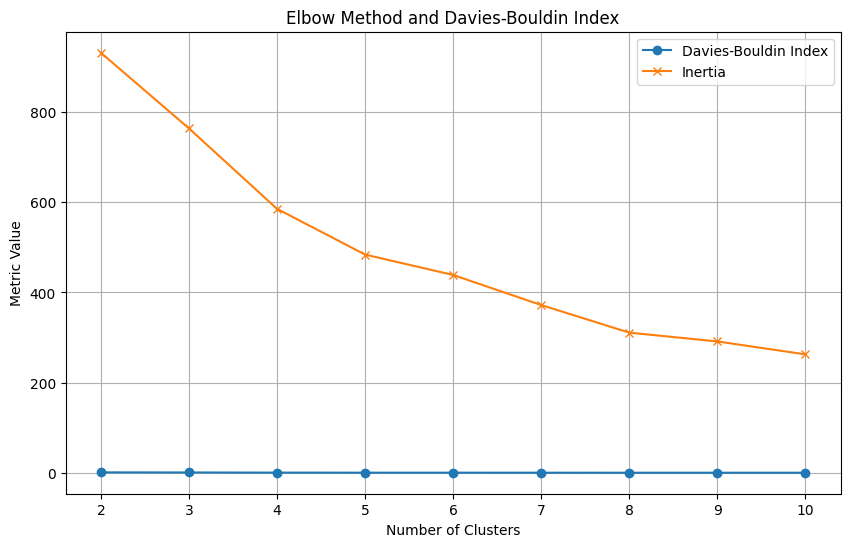

KMeans Clustering Results:
Number of Clusters: 4
Davies-Bouldin Index: 1.1926430643192663
Silhouette Score: 0.31973356884457993
Calinski-Harabasz Score: 68.63634573797445


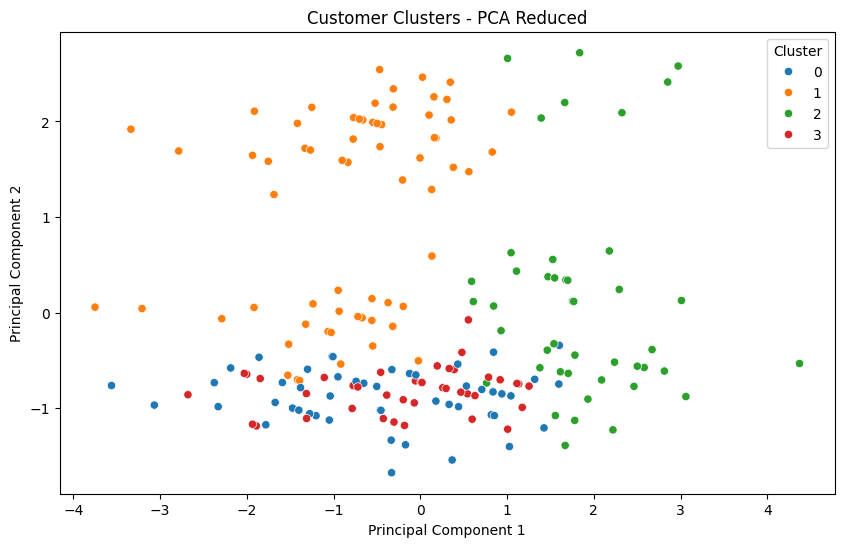

In [61]:
if __name__ == "__main__":
    # Merge datasets
    merged_df = merge_datasets()

    # Prepare features
    feature_columns = merged_df.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']).columns
    features = merged_df[feature_columns]

    # Scale features and optimize clusters
    scaled_data = optimal_number_of_clusters(features)

    # Perform KMeans clustering for the optimal number of clusters
    n_clusters = 4  # Adjust this value based on the elbow plot and Davies-Bouldin Index
    labels, centers, db_index, silhouette_avg, calinski_harabasz = perform_kmeans_clustering(scaled_data, n_clusters)

    print("KMeans Clustering Results:")
    print(f"Number of Clusters: {n_clusters}")
    print(f"Davies-Bouldin Index: {db_index}")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")

    # Visualize clusters
    visualize_clusters(scaled_data, labels)

    # Save cluster labels to dataset
    merged_df['Cluster'] = labels
    merged_df.to_csv('Customer_Clusters_Optimized.csv', index=False)
